By: Gabriel Peery

Note that the material of this Notebook is also available at https://github.com/g-peery/montecarlo-ea

# The Question

We'll investigate a 3D, cubic Edwards-Anderson model. Like the Ising model, the EA model is composed of some collection of spins with interaction energies between adjacent sites. Unlike the Ising model, however, the energy that binds sites together is allowed to vary bind-to-bind and be any real number. To study all EA configurations, rather than just one instantiation like the regular Ising model, we'll take many samples of sets of binding energies from a normal distribution with mean 0 and variance 1. The Hamiltonian, or energy, of the model is then

$$\mathcal{H}=-\sum_{\langle i,j\rangle}J_{ij}S_iS_j$$

Where $J_{ij}$ are binding energies, $\langle i,j\rangle$ denotes a sum over adjacent sites (which are in the up, down, left, right, in, and out directions from each site on a 3D cubic lattice), and $S_i\in\{-1,1\}$ are spins. This model gives rise to spin glass behavior\[1\], but differs from more computationally intensive spin glass models like the Sherrington-Kirkpatrick model in that only adjacent sites have non-zero interaction energies. This spin glass behavior is characterized by there being many different, thermally isolated local ground states at low temperatures. These states not only tend to be numerous given specific binding configurations, but they are different for most choices of configurations. To get a handle on this low temperature behavior, we can investigate two quantities, spin overlap $q$ and link overlap $q_l$\[1\]:

$$q=\frac{1}{N}\sum_{i=1}^{N}S_i^{(1)}S_i^{(2)}$$
$$q_l=\frac{1}{N_{bonds}}\sum_{\langle i,j\rangle}S_i^{(1)}S_j^{(1)}S_i^{(2)}S_j^{(2)}$$

where $N$ is the number of sites in the cubic lattice (if the lattice is $L$ sites across, then $N=L^3$), $N_{bonds}$ is the number of adjacencies between sites (here, $N_{bonds}=3L^3$), and $S_i^{(1)}$ and $S_i^{(2)}$ refer to spins of copies of the same system, matching site to site (same binding energies and temperature baths at $T$). We'll investigate what these quantities look like when averaged over choices of different states with the same binding configuration and then over choices of binding configuration. This leads us to the question:

**What do the distributions of $q$ and $q_l$ look like for Edwards-Anderson systems in general, and are the results consistent with previous investigations?**

There are other quantities that can be studied, but I found that these two are some of the easiest to compute and there is plenty of work on them in existing literature. We'll compare results against a paper by Katzgraber et al.\[1\] and also take some inspiration from a paper by Hukushima and Nemoto \[2\]. Originally, I wanted to explore another question about what happens when another term is added to the Hamiltonian, but that will need to be left to future investigations since this question alone proved difficult, and took more time both to program and run than expected.

# The Analysis

The best tool for this job is the Monte Carlo simulation; we want to gather lots of samples, weighted by probabilities as determined by Boltzmann factors and the distribution chosen for binding energies. We'll need a Monte Carlo simulations within Monte Carlo simulations: an outer sampler of binding energies $J_{ij}$ and an inner sampler of the configurations of $S_i$ at different temperatures. A difficulty arises in that we want to sample all the low temperature state landscape, but admittedly such states are thermally isolated from each other, so a traditional Metropolis-Hastings Monte Carlo simulation at a low temperature would get stuck in the same local minimum. We could try initializing at many different random configurations, but the probabilities of landing in specific low-temperature phases with such a method is not guarranteed to reflect the actual probabilities implied by the partition function. Even if it did, it would be inefficient. So, we'll use a popular variation of Monte Carlo to deal with this sampling difficulty: the Parallel Tempering Monte Carlo method\[1\].

The method works by simulating many different EA systems at the same time. Each is assigned a different temperature, but all share the same configurations at any given iteration. A few standard Metropolis-Hastings Monte Carlo iterations are run in each to explore within their own temperatures, then a new step is introduced to attempt swapping temperatures between different systems. We treat a ratio of Boltzmann factors as something akin to probability (it may be greater than one, in which case we always make the transfer), and then compare with uniform random variables to decide to swap temperatures or not. This is repeated many times for each choice of binding energy configuration. The method allows states to oscillate up and down in temperature, with each rise giving the potential to escape deep, thermally isolated wells. The systems may then fall back into a different well, with the frequency implied by Boltzmann factors.

In our case, we'll simulate two such independent sets at the same time, borrowing the method of the Katzgraber et al. paper. This allows calculating $q$ and $q_l$ after each sweep by comparing between the two sets of states at the same temperature. Note that the temperature exchanges are done independently in either set, so the pair of systems used in one Monte Carlo "sweep" to calculate overlaps may not be the same in some other sweep, assuming either in the previous pair swapped temperature. The alternative to this method is to have only one set of states at different temperatures and then compare to past iterations, but that uses lots of memory and requires careful consideration of how far back to compare, which itself requires estimating the average number of iterations it takes a state to swap temperatures from the lowest to the highest. So, we'll stick with the parallel sets method.

In past work, the choice of temperatures has been finely tuned using some initial Monte Carlo runs and some other algorithms to make the proability of temperature exchange just right\[1,2\]. Here, we'll use trial and error to get the probabilities around 30%.

The machinery to run the simulations was written and run outside of this notebook, we'll use this to study the results. Here are the two source files, an explanation of some implementation details follows:

In [1]:
%%writefile time_logging.py
"""
Module with a decorator to print how long a function takes.

Author: Gabriel Peery
Date: 6/7/2021
"""
from functools import wraps
from time import perf_counter
from typing import Callable


def print_time(func : Callable):
    """Decorator to print the time of how long a function takes."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = perf_counter()
        print(f"{start:.3f} : '{func.__name__:>32}' starting")
        ret = func(*args, **kwargs)
        end = perf_counter()
        print(f"{end:.3f} : '{func.__name__:>32}'"
              f" took {end - start:.6f} seconds")
        return ret
    return wrapper


Overwriting time_logging.py


In [2]:
%%writefile simulate.py
"""
Methods to run simulations and output data to a file for later analysis.
Directory operations only work on Windows, systems with '\\' separators.

Note that the global_move_period should be small.

Author: Gabriel Peery
Date: 6/9/2021
"""
import argparse
from json import dump
from numba import boolean, njit, prange
import numpy as np
import os
import time_logging
from typing import Tuple


SPIN_DTYPE = np.dtype("i1")
BINDING_DTYPE = np.dtype("f4")
_STATE_DTYPE = np.dtype([
    ("s", SPIN_DTYPE),    # Spin
    ("r", BINDING_DTYPE), # Right binding
    ("d", BINDING_DTYPE), # Down binding
    ("i", BINDING_DTYPE)  # In binding
])

IDX_DTYPE = np.dtype("i1") # Change if using more temperatures

HIST_COUNTER_DTYPE = np.dtype("u8") # Expected need up to 12.15e9

OVERLAP_DTYPE = np.dtype("i2")


@njit
def get_blank_states(size : int, beta_count : int) -> np.ndarray:
    """Generates a blank template for states to go in of some size. Will
    be 3D.
    """
    return np.zeros(
        (2, beta_count, size, size, size),
        dtype=_STATE_DTYPE
    )


@njit(parallel=True)
def init_rand_states(states : np.ndarray):
    """Draws binding energies according to a Gaussian distribution with
    variance 1 and center 0 and randomizes initial spins.

    Effects:
        Changes bindings and spins of states, both pairs of sets.
    """
    size = len(states[0][0])
    rand_spins = np.random.choice(np.array([-1, 1]), size=(2, size, size, size))
    rand_binding = np.random.normal(0.0, 1.0, size=(3, size, size, size))
    for stateA, stateB in zip(states[0], states[1]):
        for x in prange(size):
            for y in prange(size):
                for z in prange(size):
                    stateA[x][y][z].s = rand_spins[0][x][y][z]
                    stateB[x][y][z].s = rand_spins[1][x][y][z]
                    stateA[x][y][z].r = rand_binding[0][x][y][z]
                    stateB[x][y][z].r = rand_binding[0][x][y][z]
                    stateA[x][y][z].d = rand_binding[1][x][y][z]
                    stateB[x][y][z].d = rand_binding[1][x][y][z]
                    stateA[x][y][z].i = rand_binding[2][x][y][z]
                    stateB[x][y][z].i = rand_binding[2][x][y][z]


@njit(parallel=True)
def calc_energies(
        ss : np.ndarray,
        energies : np.ndarray
    ):
    """For each pair of states in ss, calculate the energies and put 
    them in the provided array.
    
    Effects:
        Modifies supplied energy array.
    """
    size = len(ss[0][0])
    # Loop over state indices
    for i in prange(len(ss[0])):
        energies[0][i] = energies[1][i] = 0
        # Loop over grid
        for x in prange(size):
            for y in prange(size):
                for z in prange(size):
                    energies[0][i] -= (ss[0][i][x][y][z].s * (
                        (ss[0][i][x][y][z].r*ss[0][i][(x+1)%size][y][z].s)
                        + (ss[0][i][x][y][z].d*ss[0][i][x][(y+1)%size][z].s)
                        + (ss[0][i][x][y][z].i*ss[0][i][x][y][(z+1)%size].s)
                    ))
                    energies[1][i] -= (ss[1][i][x][y][z].s * (
                        (ss[1][i][x][y][z].r*ss[1][i][(x+1)%size][y][z].s)
                        + (ss[1][i][x][y][z].d*ss[1][i][x][(y+1)%size][z].s)
                        + (ss[1][i][x][y][z].i*ss[1][i][x][y][(z+1)%size].s)
                    ))


@njit
def calc_energy_change(st : np.ndarray, c : np.ndarray) -> float:
    """Returns the change in energy that would occur if the site in the
    state st at coordinate c were flipped.
    """
    s = len(st)
    return 2 * st[c[0]][c[1]][c[2]].s * (
        st[c[0]][c[1]][c[2]].r*st[(c[0]+1)%s][c[1]][c[2]].s
        + st[c[0]][c[1]][c[2]].d*st[c[0]][(c[1]+1)%s][c[2]].s
        + st[c[0]][c[1]][c[2]].i*st[c[0]][c[1]][(c[2]+1)%s].s
        + st[(c[0]-1)%s][c[1]][c[2]].r*st[(c[0]-1)%s][c[1]][c[2]].s
        + st[c[0]][(c[1]-1)%s][c[2]].d*st[c[0]][(c[1]-1)%s][c[2]].s
        + st[c[0]][c[1]][(c[2]-1)%s].i*st[c[0]][c[1]][(c[2]-1)%s].s
    )


@njit
def calc_ss_overlap(
        stA : np.ndarray,
        stB : np.ndarray,
        x : int,
        y : int,
        z : int
    ) -> float:
    """Calculates the contribution of a single site to the link overlap,
    in all directions. Returns that contribution.
    """
    s = len(stA)
    return (
        stA[x][y][z].s * stB[x][y][z].s * (
        (stA[(x+1)%s][y][z].s*stB[(x+1)%s][y][z].s)
        + (stA[x][(y+1)%s][z].s*stB[x][(y+1)%s][z].s)
        + (stA[x][y][(z+1)%s].s*stB[x][y][(z+1)%s].s)
        + (stA[(x-1)%s][y][z].s*stB[(x-1)%s][y][z].s)
        + (stA[x][(y-1)%s][z].s*stB[x][(y-1)%s][z].s)
        + (stA[x][y][(z-1)%s].s*stB[x][y][(z-1)%s].s)
        )
    )


@njit
def _calc_sh_overlap(
        stA : np.ndarray,
        stB : np.ndarray,
        x : int,
        y : int,
        z : int
    ) -> float:
    """Calculates the contribution of a single site to the link overlap,
    but only in the right, down, and in directions (half). Returns that 
    contribution.
    """
    s = len(stA)
    return (
        stA[x][y][z].s * stB[x][y][z].s * (
        (stA[(x+1)%s][y][z].s*stB[(x+1)%s][y][z].s)
        + (stA[x][(y+1)%s][z].s*stB[x][(y+1)%s][z].s)
        + (stA[x][y][(z+1)%s].s*stB[x][y][(z+1)%s].s)
        )
    )


@njit
def calc_link_overlap(
        sA : np.ndarray,
        sB : np.ndarray
    ) -> int:
    """For a pairs of states sA and sB, calculate the link overlap index 
    by index. Return it.
    """
    size = len(sA)
    link_overlap = 0
    for x in range(size):
        for y in range(size):
            for z in range(size):
                link_overlap += _calc_sh_overlap(sA, sB, x, y, z)
    return link_overlap


@njit(parallel=True)
def calc_overlaps(
        ss : np.ndarray,
        spin_overlap : np.ndarray,
        link_overlap : np.ndarray,
        bts : np.ndarray
    ):
    """For pairs of states in ss, calculate the overlaps index by index.
    
    Effects:
        Modifies supplied overlap arrays.
    """
    size = len(ss[0][0])
    # Loop over indices into beta, as well as qoi, arrays
    for bi in prange(len(ss[0])):
        spin_overlap[bi] = link_overlap[bi] = 0
        for x in prange(size):
            for y in prange(size):
                for z in prange(size):
                    spin_overlap[bi] += (
                        ss[0][bts[0][bi]][x][y][z].s 
                        * ss[1][bts[1][bi]][x][y][z].s
                    )
                    link_overlap[bi] += _calc_sh_overlap(
                        ss[0][bts[0][bi]], ss[1][bts[1][bi]], x, y, z
                    )


@njit
def _update_obs_tbls(
        spin_tbl : np.ndarray,
        link_tbl : np.ndarray,
        spin_overlap : np.ndarray,
        link_overlap : np.ndarray
    ):
    """Updates the observation tables according to overlaps."""
    spin_offset = len(spin_tbl[0]) // 2
    link_offset = len(link_tbl[0]) // 2
    for bi, (spin, link) in enumerate(zip(spin_overlap, link_overlap)):
        spin_tbl[bi][spin + spin_offset] += 1
        link_tbl[bi][link + link_offset] += 1


@njit
def _mc_iter(
        # Arguments pertaining to only this iteration
        bi : int, # Index into betas
        si : int, # Index into this context's states
        c : np.ndarray, # Coordinate
        uniform : float,
        states : np.ndarray, # Only one half of copies
        # Global arguments
        betas : np.ndarray
    ) -> float:
    """Performs a single iteration of a monte carlo step with given
    indices into states and betas.

    Returns: 
        Resulting change in energy
    Effects:
        Flips the spin if accepted
    """
    # Check if non-positive
    energy_change = calc_energy_change(states[si], c)
    do_swap = (energy_change <= 0)

    # If positive, use the uniform
    if not do_swap:
        do_swap = (uniform < np.exp(-betas[bi] * energy_change))

    # Perform swaps, update energy and spin overlap info
    if do_swap:
        states[si][c[0]][c[1]][c[2]].s *= -1
    else:
        energy_change = 0.0

    return energy_change


@njit(parallel=True)
def mc_step(
        ss : np.ndarray,
        betas : np.ndarray,
        # Randoms
        cs : np.ndarray,
        uniforms : np.ndarray,
        # Observables
        energies : np.ndarray,
        # Index transforms
        bts : np.ndarray
    ):
    """Given states ss, information to get their temperatures, and some
    random values to use, performs a Metropolis-Hastings Monte Carlo
    step on all of them and updates quantities accordingly. The cs array 
    is of random coordinates.

    Effects:
        May swap spins in states.
        Updates energies
    """
    # Loop over indices into betas (and overlap arrays)
    for bi in prange(len(ss[0])):
        siA = bts[0][bi]
        siB = bts[1][bi]
        # A
        energies[0][siA] += _mc_iter(
            bi,
            siA,
            cs[0][bi],
            uniforms[0][bi],
            ss[0],
            betas
        )
        # B
        energies[1][siB] += _mc_iter(
            bi,
            siB,
            cs[1][bi],
            uniforms[1][bi],
            ss[1],
            betas
        )


@njit
def attempt_swap(
        bsi : np.ndarray, # Beta swap index i_beta
        energies : np.ndarray,
        betas : np.ndarray,
        bts : np.ndarray,
        stb : np.ndarray,
        swap_uniform : float,
        accepted : np.ndarray,
        attempts : np.ndarray
    ):
    """Given a random index at which to swap temperatures in the betas
    array, attempts a swap.
    """
    # Get indices into beta array of temperatures
    # that will swap
    low_i = bsi
    high_i = bsi + 1
    attempts[low_i] += 1
    # Accept or reject based on boltzmann factor
    exponent = (
        (betas[low_i] - betas[high_i])
        * (energies[bts[low_i]] - energies[bts[high_i]])
    )
    # Actual swapping
    if (exponent >= 0.0) or (swap_uniform <= np.exp(exponent)):
        accepted[low_i] += 1
        # Update state->beta first
        stb[bts[low_i]] = high_i
        stb[bts[high_i]] = low_i
        # Then swap beta->state
        bts[low_i], bts[high_i] = bts[high_i], bts[low_i]


# Initial averaging period will be over first 2**START_POWER iterations
START_POWER = 5

@time_logging.print_time
@njit
def ptmc(
        size : int,
        samples : int,
        sweeps : int,
        betas : np.ndarray,
        global_move_period : int,
        warmup_sweeps : int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Runs a Parallel-Tempering Monte Carlo simulation of an
    edwards_anderson model in a 3D cube with edge lengths size. samples
    is the number of times binding energies are recalculated and
    randomized. During each sample, two sets of systems are run
    independently. Each of the sets has a system for each of the betas 
    provided, which are run using Metropolis-Hastings Monte Carlo for 
    sweeps steps, and an attempt is made every global_move_period to 
    exchange adjacent betas of the systems. Also, the sweeps are allowed 
    to reach equilibrium for some number of sweeps.

    Returns some arrays that act as tables for link overlap time
    evolution, spin and link overlap histograms, and acceptance
    frequencies.
    """
    #
    # Memory allocation, startup
    #
    states = get_blank_states(size, len(betas))

    # Store maps between indices of beta and states to avoid huge
    # relocations.
    bts = np.zeros((2, len(betas)), dtype=IDX_DTYPE) # Beta to State
    stb = np.zeros((2, len(betas)), dtype=IDX_DTYPE) # State to Beta
    for i in range(len(betas)):
        bts[0][i] = bts[1][i] = stb[0][i] = stb[1][i] = i

    # Will initialize quantities of interest in loop
    # Indices here match states so that we don't have to swap with betas
    energies = np.zeros((2, len(betas)), dtype=BINDING_DTYPE)
    # Note that for overlaps, we'll save scaling for later
    # Indices match beta indices, but they are recalculated each save
    spin_overlap = np.zeros(len(betas), dtype=OVERLAP_DTYPE)
    link_overlap = np.zeros(len(betas), dtype=OVERLAP_DTYPE)

    # Useful quantities and other variables
    site_count = size ** 3
    real_sweeps = warmup_sweeps + sweeps
    sub_sweep_count = site_count * real_sweeps
    tot_mc_iters = samples * sub_sweep_count * len(betas) * 2
    mc_shape = (real_sweeps, site_count, 2, len(betas))
    swap_shape = (
        np.ceil(real_sweeps / global_move_period),
        len(betas),
        2
    )
    quo = rem = 0 # For Modular Operations

    #
    # Output quantities of interest (qoi)
    #
    # First is the prediction of link overlap from average energy, it
    # will be an average energy until end when it is converted to a
    # prediction of link overlap.
    # Second is the observed link overlap
    # Starts as a sum of averages, then averaged again at the end.
    time_ev_tbls = np.zeros(
        (2, len(betas), int(np.ceil(np.log2(sweeps) - START_POWER + 1))),
        dtype=BINDING_DTYPE
    )
    # Start as sums, turned to averages when put in time_ev_tbls
    avg_energies = np.zeros(len(betas), dtype=BINDING_DTYPE)
    # Will be normalized upon becoming average
    bind_count = 3 * site_count
    avg_ql = np.zeros(len(betas), dtype=BINDING_DTYPE)
    pred_norms = np.zeros(len(betas), dtype=BINDING_DTYPE)
    for bi in range(len(betas)):
        pred_norms[bi] = 1.0 / (bind_count * betas[bi])
    # Will be initialized in loop
    era = 0
    era_len = 0
    era_counter = 0

    # Each subtable is count of occurrences in bins.
    # Both start at counts, will be normalized and averaged at end.
    # Will iterate through, checking if less than until end
    q_bin_count = 2 * site_count + 1
    ql_bin_count = 2 * bind_count + 1
    # First is of spin overlap, second is link overlap
    spin_tbl = np.zeros((len(betas), q_bin_count), dtype=HIST_COUNTER_DTYPE)
    link_tbl = np.zeros((len(betas), ql_bin_count), dtype=HIST_COUNTER_DTYPE)

    # Acceptance frequencies for temperature swaps
    accepted = np.zeros(len(betas) - 1, dtype=HIST_COUNTER_DTYPE)
    attempts = np.zeros(len(betas) - 1, dtype=HIST_COUNTER_DTYPE)

    #
    # Sampling loop
    #
    print("Beginning Simulation with "+str(tot_mc_iters)+" Monte Carlo Steps")
    for sai in range(samples): # Sample index
        print("Running sample " + str(sai) + "...")

        #
        # Output control
        #
        era = 0
        era_len = 2 ** START_POWER
        era_counter = 0
        for bi in range(len(betas)):
            avg_energies[bi] = avg_ql[bi] = 0.0

        #
        # Initalize - draw overlaps from normal distribution, spins
        # in random directions
        #
        init_rand_states(states)
        calc_energies(states, energies)
        calc_overlaps(states, spin_overlap, link_overlap, bts)

        #
        # Generate randoms - this could take up lots of memory
        #
        print("Generating randoms...")
        rand_coords = np.random.randint(0, size, size=(*mc_shape, 3))
        mc_uniforms = np.random.rand(*mc_shape)
        swap_idxs = np.random.randint(0, len(betas) - 1, size=swap_shape)
        swap_uniforms = np.random.rand(*swap_shape)
        print("...finished randoms.")

        #
        # Sweeping loop
        #
        for swi in range(real_sweeps): # Sweep index
            #
            # Metropolis-Hastings Monte-Carlo
            #
            for ssi in range(site_count): # Sub-sweep index
                mc_step(
                    states,
                    betas,
                    rand_coords[swi][ssi],
                    mc_uniforms[swi][ssi],
                    energies,
                    bts
                )

            #
            # Record data after warmup
            #
            if swi >= warmup_sweeps:
                # Recalculate overlaps
                calc_overlaps(states, spin_overlap, link_overlap, bts)

                # Time Evolution Tables
                # Contribute to average (starting as sums)
                for bi in range(len(betas)):
                    avg_energies[bi] += (
                        energies[0][bts[0][bi]]
                        + energies[1][bts[1][bi]]
                    )
                    avg_ql[bi] += link_overlap[bi]
                era_counter += 1
                # Check if time to update table
                # Has the effect of doubling save period each time
                if era_counter == era_len:
                    # Add to table
                    for bi in range(len(betas)):
                        time_ev_tbls[0][bi][era] += avg_energies[bi] / era_len
                        #time_ev_tbls[0][bi][era] += 1 - (
                            #pred_norms[bi] * np.abs(avg_energies[bi]) / era_len
                        #)
                        time_ev_tbls[1][bi][era] += avg_ql[bi] / (
                            era_len * bind_count
                        )
                        # Reset averages after every era
                        avg_energies[bi] = avg_ql[bi] = 0.0
                    # Increments
                    era += 1
                    era_len *= 2
                    era_counter = 0

                # Observation Tables (Later Histogram Tables)
                _update_obs_tbls(
                    spin_tbl,
                    link_tbl,
                    spin_overlap,
                    link_overlap
                )

            #
            # Periodic Temperature Swap
            #
            quo, rem = np.divmod(swi, global_move_period)
            if rem == 0:
                # Attempt swaps equal to number of betas
                for swt in range(len(betas)): # Swap trial
                    # Swap A
                    attempt_swap(
                            swap_idxs[quo][swt][0],
                            energies[0],
                            betas,
                            bts[0],
                            stb[0],
                            swap_uniforms[quo][swt][0],
                            accepted,
                            attempts
                        )
                    # Swap B
                    attempt_swap(
                            swap_idxs[quo][swt][1],
                            energies[1],
                            betas,
                            bts[1],
                            stb[1],
                            swap_uniforms[quo][swt][1],
                            accepted,
                            attempts
                        )

        # Endpoint of Time Evolution Table
        if era_counter != 0:
            # Add to table
            for bi in range(len(betas)):
                time_ev_tbls[0][bi][era] += avg_energies[bi] / era_counter
                #time_ev_tbls[0][bi][era] += 1 - (
                    #pred_norms[bi] * np.abs(avg_energies[bi]) / era_counter
                #)
                time_ev_tbls[1][bi][era] += avg_ql[bi] / (
                    era_counter * bind_count
                )
                    
    #
    # Return, prepare data first
    #
    # Turn into average
    time_ev_tbls /= samples
    for x in range(len(time_ev_tbls[0])):
        for y in range(len(time_ev_tbls[0][x])):
            time_ev_tbls[0][x][y] = 1 - (
                pred_norms[x] * np.abs(time_ev_tbls[0][x][y])
            )
    # Turn into average
    spin_hist_tbl = spin_tbl / (samples * sweeps)
    link_hist_tbl = link_tbl / (samples * sweeps)
    return time_ev_tbls, spin_hist_tbl, link_hist_tbl, (accepted / attempts)


def ptmc_main():
    # Parse Arguments
    print("Parsing arguments...")
    parser = argparse.ArgumentParser(
        description="Run a Parallel-Tempering Monte Carlo simulation of "
                    "an Edwards-Anderson model in 3D."
    )
    parser.add_argument("size", type=int, help="Side length of cube.")
    parser.add_argument(
        "samples",
        type=int,
        help="Number of binding configs to sample"
    )
    parser.add_argument(
        "sweeps",
        type=int,
        help="Metropolis-Hastings iterations per binding config."
    )
    parser.add_argument(
        "global_move_period",
        type=int,
        help="Attempt temperature swapping every this iterations."
    )
    parser.add_argument(
        "warmup_sweeps",
        type=int,
        help="Iterations to calm down."
    )
    parser.add_argument(
        "min_temp",
        type=float,
        help="Minimum temperature"
    )
    parser.add_argument(
        "max_temp",
        type=float,
        help="Maximum temperature"
    )
    parser.add_argument(
        "temp_count",
        type=int,
        help="Number of temperatures in range"
    )
    parser.add_argument(
        "out_name",
        type=str,
        help="Directory to output results to."
    )
    args = parser.parse_args()
    size = args.size
    samples = args.samples
    sweeps = args.sweeps
    global_move_period = args.global_move_period
    warmup_sweeps = args.warmup_sweeps
    min_temp = args.min_temp
    max_temp = args.max_temp
    temp_count = args.temp_count
    out_name = args.out_name
    print("...finished parsing arguments.")

    # Prepare directory
    print("Preparing directory...")
    if not os.path.exists(out_name):
        os.makedirs(out_name)
    # Write config.json
    with open(out_name + r"\config.json", "w") as config:
        dump({
            "size" : size,
            "samples" : samples,
            "sweeps" : sweeps,
            "global_move_period" : global_move_period,
            "warmup_sweeps" : warmup_sweeps,
            "min_temp" : max_temp,
            "max_temp" : max_temp,
            "temp_count" : temp_count
        }, config)
    # Write meta.csv
    temps = np.linspace(min_temp, max_temp, temp_count)
    betas = temps ** (-1)
    with open(out_name + r"\meta.csv", "w") as meta:
        meta.write("Index,Beta,Temperature\n")
        for idx, (beta, temp) in enumerate(zip(betas, temps)):
            meta.write(f"{idx},{beta},{temp}\n")
    print("...finished.")

    # Run simulation
    time_ev_tbls, spin_tbl, link_tbl, acceptance = ptmc(
        size,
        samples,
        sweeps,
        betas,
        global_move_period,
        warmup_sweeps
    )

    # Write link_energy_predict.csv
    print("Writing results...")
    with open(out_name + r"\link_energy_predict.csv", "w") as lep:
        for row in time_ev_tbls[0]:
            lep.write(",".join([str(item) for item in row]) + "\n")
    # Write link_time.csv
    with open(out_name + r"\link_time.csv", "w") as lt:
        for row in time_ev_tbls[1]:
            lt.write(",".join([str(item) for item in row]) + "\n")
    # Write spin.csv
    with open(out_name + r"\spin.csv", "w") as spin_fd:
        for row in spin_tbl:
            spin_fd.write(",".join([str(item) for item in row]) + "\n")
    # Write link.csv
    with open(out_name + r"\link.csv", "w") as link_fd:
        for row in link_tbl:
            link_fd.write(",".join([str(item) for item in row]) + "\n")
    # Write accept.csv
    with open(out_name + r"\accept.csv", "w") as accept_fd:
        for ratio in acceptance:
            accept_fd.write(f"{ratio}\n")
    print("...finished.")


if __name__ == "__main__":
    ptmc_main()


Overwriting simulate.py


The ```simulate.py``` program is invoked through the command line, and explanation of arguments can be printed with ```simulate.py -h```. It imports ```time_logging.py``` to print information about how long it takes to run. Many of its individual methods use the Numba ```njit``` decorator, which uses just-in-time compilation to make for faster runtime at a cost of some Pythonic features and compatibility with debugging tools. Numba also provides access to automatic parallelization features, as in ```parallel=True```, which allows compatible methods to be split up and worked on by multiple processes simultaneously.

I'll let the comments and docstrings explain some of the minutia of the Monte Carlo implementions, but basically NumPy arrays are used for a variety of purposes: storing data that will later be saved to files, keeping big blocks of random numbers, holding the states themselves, and more. Their dimensionality tends to be higher than usual because states need to be indexed by which of the independent sets they are in, the specific one in the set with a temperature that may be changed, and then each state has all of its spins and binding energies packed into a 3D grid. The Metropolis-Hastings steps should look familiar, and the temperature swapping steps work as described, but specifically by swapping around indices into the array of "betas", which are inverse temperatures. This was chosen to avoid large copying operations, at the cost of keeping two arrays to translate between indices into the state arrays and into the temperature/beta array.

The user specifies information like how many sites across the 3D cubic lattice should be, how many samples of bindings $J_{ij}$ should be made, how many sweeps within each binding configuration should be made, how often to attempt to swap adjacent temperatures, how many iterations to let the system calm down before data collection, what temperatures should states be allowed to occupy and potentially swap between, and finally a name of the simulation. This name is used to create a directory inside of which files are created to contain information about the settings used in the simulation and the data that we will read into this notebook.

We will analyze two simulations, chosen for similarity with the Katzgraber et al. paper and feasibility given the optimizations used and the hardware available to me. Many others were run during the debugging process.

1. The first simulation, called "big," was run overnight to crunch through 16 billion individual Metropolis-Hastings iterations and over 100 million temperature swapping steps. A grid with 4 sites across, temperatures were chosen according to trial and error with some shorter runs to make acceptance ratios be about the desired 30%. It was run with the following command: ```simulate.py 4 2000 10000 1 1000 0.2 2.0 6 big```, which may be translated: 4 sites across, 2000 binding energy samples, 10000 sweeps per sample, every 1 sweep attempt some temperature swaps, do 1000 warmup sweeps per sample, the lowest temperature should be 0.2 and the highest should be 2 for a total of 6, and store it in a directory called "big."
2. The next simulation was much smaller and temperatures weren't chosen as carefully. We'll take a look to see how sensitive the method is to change, and also to take a look at a different sized cube (it only had 3 sites across). It was run with the following command: ```simulate.py 3 100 10000 1 1000 0.1 2.0 6 three```, which means: 3 sites across, 100 binding energy samples, 10000 sweeps per sample, every 1 step attempt some temperature swaps, do 1000 warmup sweeps per sample, the lowest temperature should be 0.2 and the highest should be 2 for a total of 6, and store it in a directory called "three."

We'll read in the results in this notebook, let's write some code to make it easier:

In [3]:
from json import load
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

After importing everything we need, let's introduce a class to store the information and provide methods to study it. We'll also create a method to put information from the directories into class instances:

In [4]:
class SimResult:
    """Class to store results of a simulation, plot information about them. Best
    if used as return of read_results method.
    """
    
    def __init__(self,
        link_energy_predict : pd.DataFrame,
        link_time : pd.DataFrame,
        spin : pd.DataFrame,
        link : pd.DataFrame,
        meta : pd.DataFrame,
        config : dict,
        accept : pd.DataFrame
    ):
        """Stores information about a simulation, providing a convenient
        container for plotting.
        """
        self.link_energy_predict = link_energy_predict
        self.link_time = link_time
        self.spin = spin
        self.link = link
        self.meta = meta
        self.config = config
        self.accept = accept
        
    def plot_equilibration(self, temp_idx : int):
        """Uses PyPlot to display a plot of link overlap as predicted during
        equilibration and as observed in the simulation as a function of Monte
        Carlo sweep, for the data at some temperature index.
        """
        # Put stuff on the plot
        plt.xscale("log")
        sweep_numbers = -1 + (2**(np.arange(len(self.link_time.iloc[0])) + 9))
        link_from_energy = np.array(list(self.link_energy_predict.iloc[temp_idx]))
        link_observed = np.array(list(self.link_time.iloc[temp_idx]))
        plt.plot(sweep_numbers, link_from_energy, "o-r", label="Predicted")
        plt.plot(sweep_numbers, link_observed, "o-b", label="Observed")
        
        # Setup labels
        this_temp = self.meta["Temperature"][temp_idx]
        plt.title(
            f"Link Overlap vs. Monte Carlo Sweep Number at T={this_temp:.2}"
        )
        plt.xlabel("$N_{sweep}$")
        plt.ylim([0,1])
        plt.ylabel("$q_l$")
        plt.legend()
        plt.show()
        
    def plot_spin_dist(self, temp_idx : int):
        """Uses PyPlot to show a histogram of the spin overlaps observed during
        the simulation, for the states at some temperature determined by the
        index.
        """
        # Put on the plot
        q_values = np.linspace(-1, 1, len(self.spin.iloc[temp_idx]))
        freqs = self.spin.iloc[temp_idx]
        # Some bins are always empty
        plt.bar(q_values, freqs, 4/len(self.spin.iloc[temp_idx]))
        
        # Setup labels
        this_temp = self.meta["Temperature"][temp_idx]
        plt.title(f"Distribution of Spin Overlap at T={this_temp:.2}")
        plt.xlim(-1.1, 1.1)
        plt.xlabel("$q$")
        plt.ylabel("$P(q)$")
        plt.show()
        
    def plot_link_dist(self, temp_idx : int):
        """Uses PyPlot to show a histogram of the link overlaps observed during
        the simulation, for the states at some temperature determined by the
        index.
        """
        # Put on the plot
        ql_values = np.linspace(-1, 1, len(self.link.iloc[temp_idx]))
        freqs = self.link.iloc[temp_idx]
        plt.bar(ql_values, freqs, 8/len(self.link.iloc[temp_idx]))
        
        # Setup labels
        this_temp = self.meta["Temperature"][temp_idx]
        plt.title(f"Distribution of Link Overlap at T={this_temp:.2}")
        plt.xlim(-1.1, 1.1)
        plt.xlabel("$q_l$")
        plt.ylabel("$P(q_l)$")
        plt.show()
        
    def plot_acceptance(self):
        """Uses PyPlot to display a plot of acceptance ratios versus temperature
        """
        # Put stuff on the plot
        temp = np.array(list(self.meta["Temperature"]))
        ratios = np.array(list(self.accept[0]))
        plt.plot(temp[:-1], ratios, "o-g")
        
        # Setup labels
        plt.title(
            "Acceptance Ratio vs. Temperature"
        )
        plt.xlabel("$T$")
        plt.ylabel("Acceptance Ratio")
        plt.show()
    
    
# NOTE: This only works for Windows, systems with '\' as directory separator
def read_results(name : str) -> SimResult:
    """Given a name of a simulation, reads in data from the directory.
    
    Returns corresponding DataFrame's and dictionary of its configuration in a
    special class.
    """
    link_energy_predict = pd.read_csv(
        name + r"\link_energy_predict.csv",
        header=None
    )
    link_time = pd.read_csv(
        name + r"\link_time.csv",
        header=None
    )
    spin = pd.read_csv(
        name + r"\spin.csv",
        header=None
    )
    link = pd.read_csv(
        name + r"\link.csv",
        header=None
    )
    meta = pd.read_csv(
        name + r"\meta.csv",
        index_col=0
    )
    with open(name + r"\config.json") as config_file:
        config = load(config_file)
    accept = pd.read_csv(
        name + r"\accept.csv",
        header=None
    )
    return SimResult(
        link_energy_predict,
        link_time,
        spin,
        link,
        meta,
        config,
        accept
    )

The following method isn't used in the following analysis, but it provides a quick way to look at all the details of a run, which is useful for debugging:

In [5]:
def full_suite_analysis(name : str):
    """Reads in a result, plots all the things"""
    sr = read_results(name)
    sr.plot_acceptance()
    for i in range(len(sr.meta.index)):
        sr.plot_equilibration(i)
    for i in range(len(sr.meta.index)):
        sr.plot_spin_dist(i)
    for i in range(len(sr.meta.index)):
        sr.plot_link_dist(i)
    return sr

Now, let's get to it:

## "big"

We'll start by reading in the files of the directory and plotting "acceptance ratios." Inspired by the Hukushima and Nemoto paper\[2\], this displays the fraction of the time swaps from some temperature to the next greatest were accepted. This allows trial and error to find good settings, at least given that my implementation doesn't use automated discovery. For this simulation, the trial and error was already done, so this is simply verification that we're looking at something efficient and reasonable:

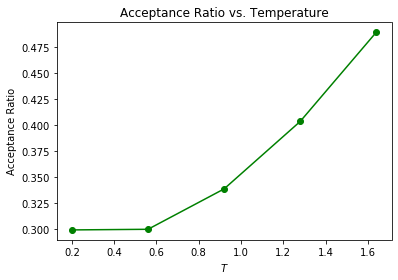

In [6]:
# Get an instance of a class after reading from file
big_sim = read_results("big")
# Plot acceptance ratios
big_sim.plot_acceptance()

The ratios are reasonably close to our target, which is a source of confidence. To further build confidence, one method to see if enough samples are taken to reach "equilibriation" is to compare a cumulative average of link overlap $q_l$ to a prediction derived from cumulative average energy per site $U$\[1\]:

$$\langle q_l\rangle=1-\frac{T|U|}{3}$$

Where averages are within their own temperatures. The observed average $q_l$ should converge closer and closer to this prediction with more Monte Carlo sweeps, and do it faster with more samples of binding $J_{ij}$. After such a point, we expect $q_l$ to stay relatively constant. Let's take a look at what plots of their averages over samples versus sweep number look like at a few temperatures:

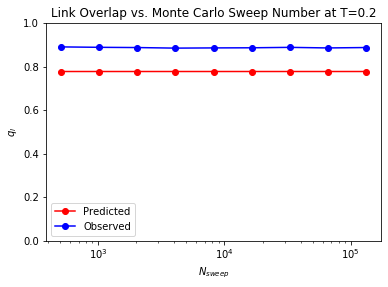

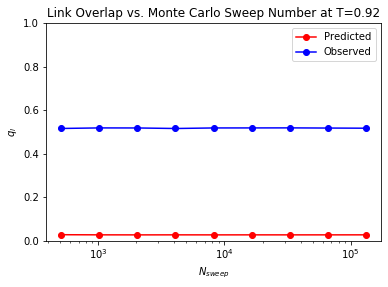

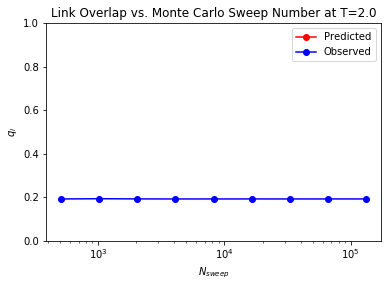

In [7]:
# Remove the last point in the plots; it suffers from two little samples during
# the last sweeps
big_sim.link_energy_predict.drop(9, 1, inplace=True)
big_sim.link_time.drop(9, 1, inplace=True)

# Plotting by temperature index
big_sim.plot_equilibration(0)
big_sim.plot_equilibration(2)
big_sim.plot_equilibration(5)

$q_l$ seems steady the whole time, and so does the predicted value from $U$. As expected, $q_l$ declines with temperature as a result of states being able to be more random. Beyond that, however, the two don't seem to agree at all! In fact, the predicted value drops below the observed value. More investigation is needed, but we'll proceed with cautious optimism.

Let's take a look at distributions of spin overlap $q$. Previous results suggest that they are symmetric about 0.0, and tend to peak near extreme values at low temperatures\[1\]. At high temperatures, we can expect lots of probability mass to be near zero since states are allowed more freedom and randomness. Since the question we are pursuing here is what these distributions look like, we'll plot them for each temperature explored:

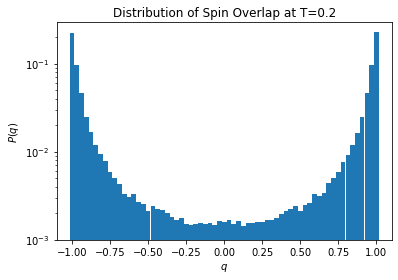

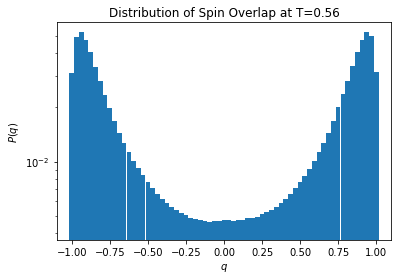

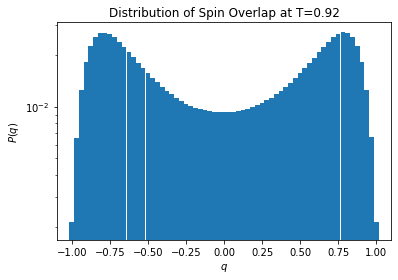

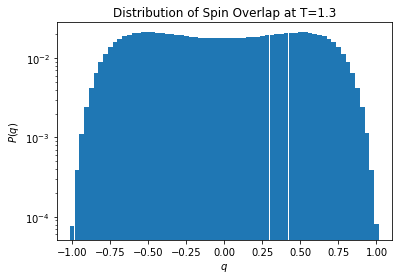

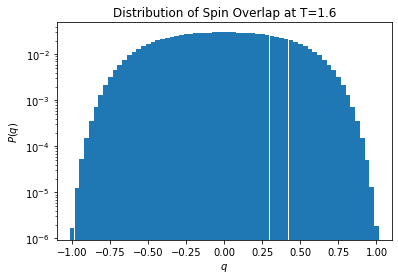

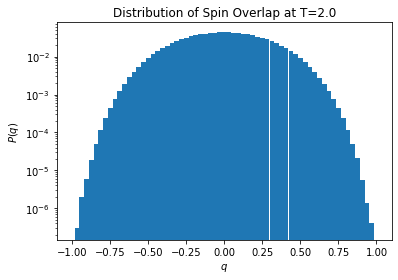

In [8]:
# For each temperature index, display the plot
# Meta stores information about temperatures and inverses (betas)
for i in range(len(big_sim.meta.index)):
    plt.yscale("log")
    big_sim.plot_spin_dist(i)

Barring some graphical effects from PyPlot, this very much agrees with the Katzgraber et al. paper. Like the paper, note that we used a logarithmic scale. It also agrees with intuitions about higher temperatures.

With renewed confidence, let's take a look at link overlap $q_l$:

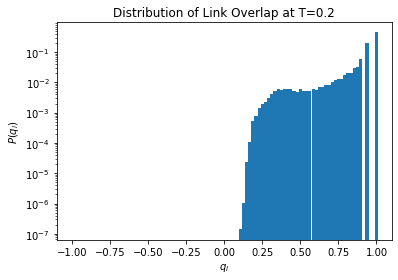

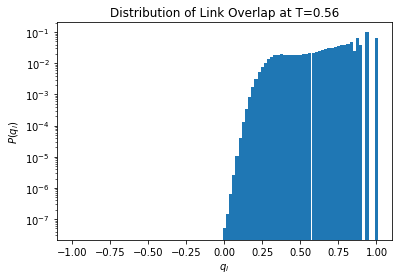

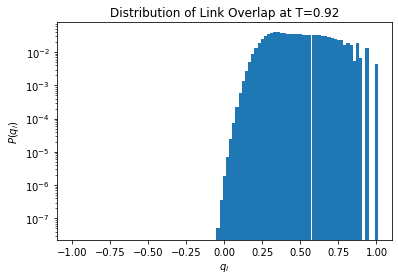

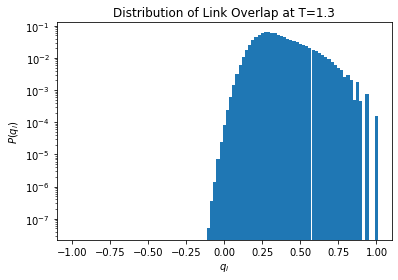

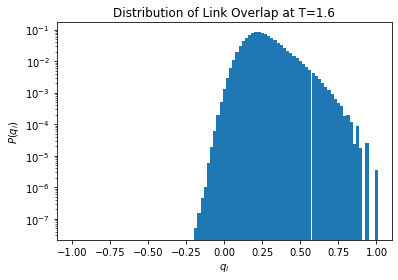

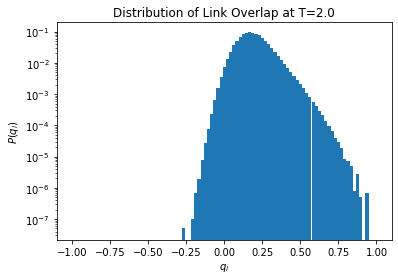

In [9]:
# For each temperature index, display the plot
# Meta stores information about temperatures and inverses (betas)
for i in range(len(big_sim.meta.index)):
    plt.yscale("log")
    big_sim.plot_link_dist(i)

This also shows broad agreement with the reference paper. There are some gaps near the extreme ends of the plots that may be inconsistencies; we'll discuss further in the conclusion. These plots are consistent with the moving averages seen in our first plot, suggesting that $q_l$ skews positive.

## "three"

This simulation was three sites across, and not much data was gathered compared to the big simulation. Despite this, some valuable data was gathered. We'll start with acceptance ratios again.

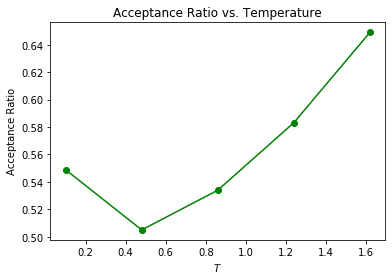

In [10]:
# Get an instance of a class after reading from file
three = read_results("three")
# Plot acceptance ratios
three.plot_acceptance()

Acceptance ratios are about twice as high as is ideal. In its current state, the simulation only deals with temperatures in an arithmetic progression, which restricts flexibility in adjusting the temperature settings for the $L=3$ case. If there are too few temperatures, then there isn't much data gathered for temperatures near the EA model's phase transition. If the range is too large, then there will be lots of wasted computation power simulating states at higher energies where we already have a good idea of what distributions look like. Despite this, we'll press on and see how the results are different from the literature and the previous simulation.

Let's take a look at the evolution of link overlap and the predicted value for a variety of temperatures:

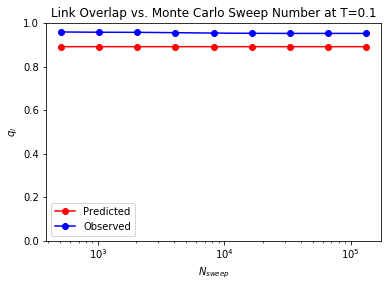

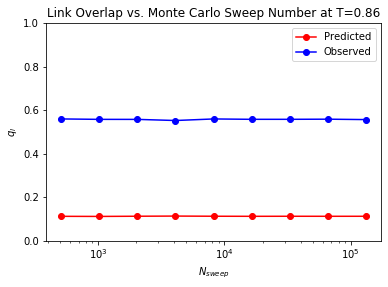

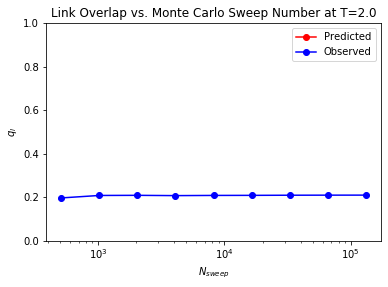

In [11]:
# Remove the last point in the plots; it suffers from two little samples during
# the last sweeps, similar to "big"
three.link_energy_predict.drop(9, 1, inplace=True)
three.link_time.drop(9, 1, inplace=True)

# Plotting by temperature index
three.plot_equilibration(0)
three.plot_equilibration(2)
three.plot_equilibration(5)

As before, the predicted value from average energy per site stays steady but drops below the observed value, becoming worse with higher temperatures. Visually, there is a bit more variance in either series, but it is still quite steady.

We'll print all the distributions at the same time, plots for different temperatures being adjacent, rather than putting spin and link overlap into different sections:

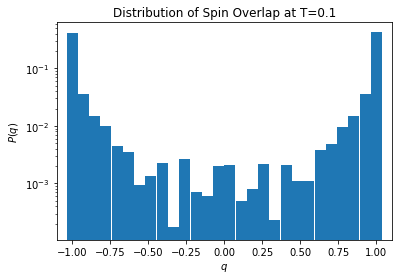

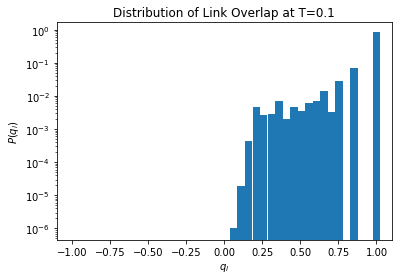

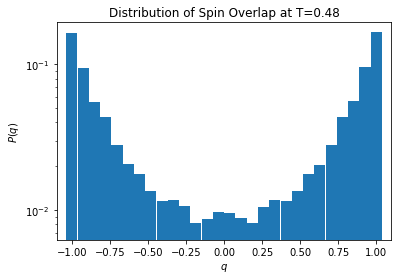

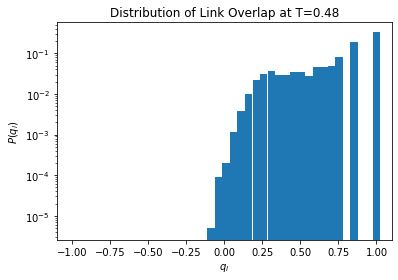

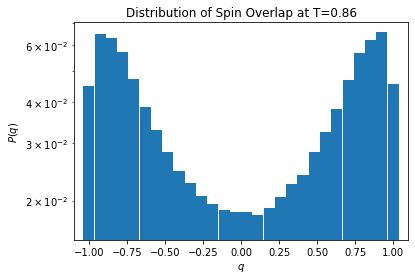

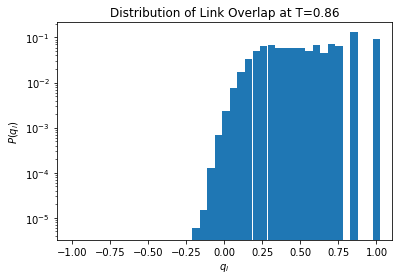

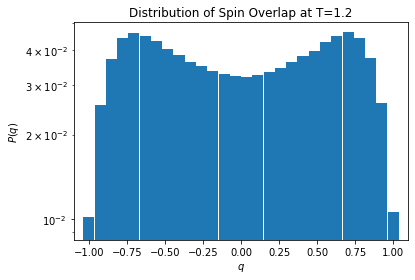

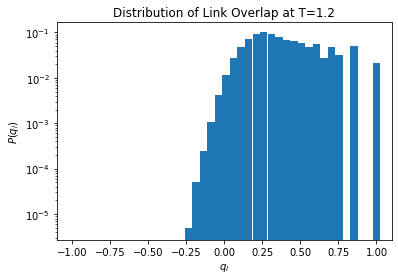

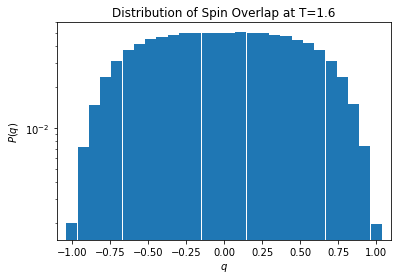

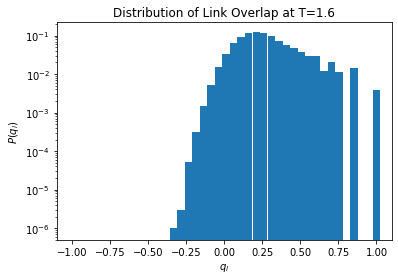

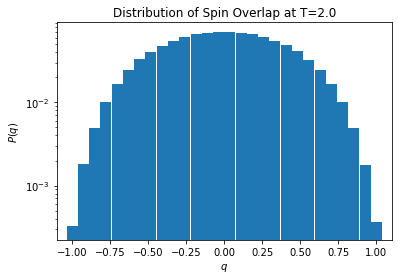

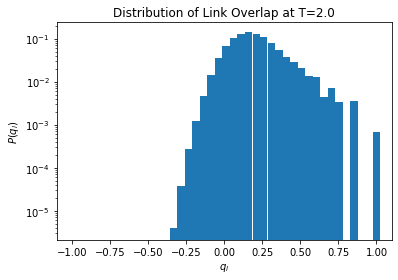

In [12]:
# For each temperature index, display the plots
# Meta stores information about temperatures and inverses (betas)
for i in range(len(three.meta.index)):
    plt.yscale("log")
    three.plot_spin_dist(i)
    plt.yscale("log")
    three.plot_link_dist(i)

Note that histogram bars are thicker due to there being less possible values of $q$ and $q_l$, not because there is less data. Gaps and inperfections are pronounced (the data is noisy), but there is still qualitative agreement with results in existing literature and intuitive expectations.

## Conclusion

"The spin glass problem is hard"\[3\]. As for what the distributions look like, spin overlap tends to be large for small temperatures in both lattice sizes simulated. This suggests that although individual states tend to be numerous, for any given configuration they tend to be quite similar in the deepest thermodynamic wells, or at least allow flipped versions of themselves. Increasing temperature shifts probability mass inward, consistent with both more potential for randomness and the existence of shallower wells that differ from those at the lowest temperatures. Link overlap skews positive at all temperatures, but is most positive and extreme at low temperatures. This provides further evidence that spin glass states at low temperatures tend to be similar to each other at low temperatures. Further, its tendency to positive values is suggestive of agreement between different states in the way of adjacent sites either being misaligned (ie. up and down) or aligned (both up or both down). This is contrasted by the possibility of large scale behavior interfering with local preferences, which apparently doesn't happen strongly in this model.

The second part of the question was whether the distributions qualitatively agree with existing literature, which appears true with some caveats. Even in the noisy second dataset, the shapes are qualitatively similar to those found by Katzgraber et al. There is a difference in scaling, but that is because they plotted probability densities in a sophisticated fashion (allowing for values greater than 1), while I merely plotted a histogram. With my data visualization, I notice some conspicuous holes near the extreme values of link overlap. This doesn't appear to be a plotting error, since the frequencies that are present do add up to normality (1.0). The explanation has to do with the mathematical reachability of larger values. Take, for example, two states whose link overlap is calculated where both in both states all sites have spin 1. Link overlap is 1.0. If only one of the spins is flipped, then link overlap will decrease by -$\frac{4}{L^3}$. There is no chance to visit intermediate values. For smaller values of $q_l$, there are many different associated pairs of configuration.

Though not part of the orginal question, there was some oddity with the average $q_l$ versus prediction from $U$ equilibrium metric. I'm still not completely sure what is going on there, though I have a hypothesis regarding why both remain relatively flat. Keeping what I learned from the last final project in mind, I programmed the innermost Metropolis-Hastings Monte Carlo sweeps to attempt a spin swap at random coordinates, but a random coordinate for each spin on the lattice for each iteration. Simulations referenced in the literature may not have done that, so my effective iteration count may be higher than theirs, leading to quicker equilibria. I am at a loss as to what is going on with the prediction from energy per spin, but that would be a good direction for future experimentation.

# Future Directions

More simulations can be done with this program, which may involve different temperature ranges, more iterations, and different sizes of lattice. There is also plenty of room to improve it including allowing the user more flexibility in choosing temperatures or implementing automated temperature selection, further optimization and tuning, and perhaps using Numba's CUDA random number generating capabilities. The code here would also be a good starting point to implement different types of lattices, such as different space-filling lattice styles, higher dimensional lattices, and different distributions of binding energies. Other quantities like magnetization could be investigated without changing much, and such might be helpful for further investigation into why this simulation's equilibrium metric didn't agree with past work.

Specifically, the biggest change I might make in the future is to try to distribute computations over separate computers entirely and over networks. With such a speedup, and potentially others like graphics card usage, I would like to add another, mixed-$p$-spin-like term to the Edwards-Anderson Hamiltonian like so:
$$\mathcal{H_{new}}=-\sum_{\langle i,j\rangle}J_{ij}S_iS_j-\sum_{\langle i,j,k,l\rangle}J_{ijkl}S_iS_jS_kS_l$$
where the second term describes bonds over groups of 4 vertices, which I would choose according to squares formed by the former type of bond along the $x$, $y$, and $z$ planes. I believe such an extension is natural, lends itself to similar analysis of spin, link, and other analagous overlaps, and differences with Edwards-Anderson would be interesting.

The parallel tempering technique is powerful, and could be applied to other spin glass models like Sherrington-Kirkpatrick and $p$-spin models, which may also have nice spin and link overlap properties.

# References

\[1\] Helmut G. Katzgraber, Matteo Palassini, A. P. Young: “Monte Carlo Simulations of Spin Glasses at Low Temperatures”, 2000, Phys. Rev. B 63, 184422, (2001); arXiv:cond-mat/0007113. DOI: 10.1103/PhysRevB.63.184422.

\[2\] Koji Hukushima, Koji Nemoto: “Exchange Monte Carlo Method and Application to Spin Glass Simulations”, 1995; arXiv:cond-mat/9512035. DOI: 10.1143/JPSJ.65.1604.

\[3\] A. P. Young: “Numerical Simulations of Spin Glasses”, 2006; Lecture Notes in Physics. DOI: 10.1007/3-540-35284-8_2.